<a href="https://colab.research.google.com/github/jvataidee/PesquisaOperacional/blob/master/otimiza%C3%A7%C3%A3o_caraga_caminh%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://static.wixstatic.com/media/bdd7cb_58ee4016e6f549df966e85f5d0e49fc9~mv2.png" height="55px">

**by: [João Ataíde](https://www.joaoataide.com)**
# **Otimização de cargas com algoritmo genético**


---


<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_f77572eb85d049688987c967d9038104~mv2.jpg"></p>




In [ ]:
!pip install deap -q

In [ ]:
import numpy as np
import random
import pandas as pd
from deap import base, creator, algorithms, tools
import matplotlib.pyplot as plt
import seaborn as sns

#configurações de gráficos
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Importando os dados

In [ ]:
!pip install kaggle -q

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d olistbr/brazilian-ecommerce

brazilian-ecommerce.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

 brazilian-ecommerce.zip   files  'kaggle (1).json'   kaggle.json   sample_data


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('brazilian-ecommerce.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [ ]:
df_items = pd.read_csv('/content/files/olist_order_items_dataset.csv')
df_produto = pd.read_csv('/content/files/olist_products_dataset.csv')

In [ ]:
print(df_items.shape)
df_items.head()

(112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
print(df_produto.shape)
df_produto.head()

(32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


### Prepararo do dataset

In [ ]:
#Escolher variáleis as necesárias
df_items = df_items.iloc[:, [2,5,6]]
df_produto = df_produto.iloc[:, [0,1,5,6,7,8]]

In [ ]:
#Indexar o id do produto
df_items = df_items.set_index('product_id')
df_produto = df_produto.set_index('product_id')

In [ ]:
 #Realizar um join entre as tabelas
 df = df_items.join(df_produto)

In [ ]:
#Calcular o volume e preço total de cada produto
df["volume"] = df["product_length_cm"]*df["product_height_cm"]*df["product_width_cm"]
df["preco"] =  df["price"]+df["freight_value"]
df = df.reset_index()

In [ ]:
#Escolher dataset final
produtos = df.iloc[:, [0,3, 4 ,8,9]]
produtos.head()

,product_id,product_category_name,product_weight_g,volume,preco
0,00066f42aeeb9f3007548bb9d3f33c38,perfumaria,300.0,5120.0,120.24
1,00088930e925c41fd95ebfe695fd2655,automotivo,1225.0,14300.0,143.83
2,0009406fd7479715e4bef61dd91f2462,cama_mesa_banho,300.0,23625.0,242.10
3,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,550.0,5472.0,78.50
4,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,550.0,5472.0,78.50


## Criando o Algoritimo Genético

Tipo de caminhão VUC

<p align="center"><img src="https://www.4truck.com.br/site/wp-content/uploads/2016/02/4truck-mb-accelo-818-corrugado-natural-vuc-02.jpg"></p>

<p align="center"><img src="https://www.truckpad.com.br/uploads/2017/01/329981fc-medidas-carrocerias-3.png"></p>

In [ ]:
#lmimte de espaço no caminhão
limtie_espacos = 2.2*7.2*3.5*100  #grandeza em centimetros
limtie_peso = 4e+6   #grandeza em gramas

In [ ]:
#Criar Classe do Produto
class Produto():
    def __init__(self, nome, pesos, volume, valores):
        self.nome = nome
        self.pesos = pesos 
        self.volume = volume
        self.valor = valor

In [ ]:
#Criando listas de produtos
lista_produtos = []

for i in range(len(produtos)):
  lista_produtos.append(produtos.loc[i])

In [ ]:
#Transformar em listas
espacos = list(produtos.volume)
valores = list(produtos.preco)
nome = list(produtos.product_id)
pesos = list(produtos.product_weight_g)

In [ ]:
#Criar a função de avaliação
def avaliacao(individual):
    nota = 0 
    soma_espacos = 0
    soma_pesos = 0

    for i in range(len(individual)):
        if individual[i] == 1:
            nota += valores[i]
            soma_espacos += espacos[i]
            soma_pesos += pesos[i]
            
    if soma_espacos > limtie_espacos and soma_pesos > limtie_peso:
      nota = 1

    return nota / 100000, 

In [ ]:
#Criar a toolbox
toolbox = base.Toolbox()

#Criando parâmetros na toolbox
creator.create("FitnessMax",  base.Fitness, weights = (1.0, ))
creator.create("Individual", list, fitness = creator.FitnessMax)

#Registrando na toolbox
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n = len(espacos))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", avaliacao)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb = 0.05)
toolbox.register("select", tools.selRoulette)

In [ ]:
#Iniciando a toolbox
if __name__ == "__main__":
    population = toolbox.population(n = 24)
    probabilidade_crossover = 5.0
    probabilidade_mutação = 0.03
    numero_gerações = 250
    
    estatisticas = tools.Statistics( key = lambda individuo: individuo.fitness.values)
    estatisticas.register("max", np.max)
    estatisticas.register("min", np.min)
    estatisticas.register("med", np.mean)
    estatisticas.register("std", np.std)
    
    populacao, info = algorithms.eaSimple(population, toolbox, 
                                          probabilidade_crossover, 
                                          probabilidade_mutação,
                                          numero_gerações, estatisticas)

gen	nevals	max    	min   	med    	std     
0  	24    	79.9591	78.701	79.1992	0.331206
1  	24    	79.9318	78.6237	79.2077	0.3424  
2  	24    	79.8513	78.6285	79.1513	0.430863
3  	24    	79.905 	78.6357	79.1404	0.282755
4  	24    	79.8797	78.6513	79.2066	0.310564
5  	24    	80.0477	78.5775	79.2919	0.350592
6  	24    	79.9106	78.591 	79.3156	0.362643
7  	24    	79.9587	78.8826	79.3995	0.275657
8  	24    	80.1788	78.5785	79.3905	0.352929
9  	24    	80.0275	78.5022	79.3603	0.395229
10 	24    	79.835 	78.793 	79.2319	0.323157
11 	24    	79.8152	78.7749	79.1489	0.270432
12 	24    	79.694 	78.3128	79.129 	0.354966
13 	24    	80.1194	78.6419	79.2765	0.332168
14 	24    	79.5716	78.6238	79.2442	0.258525
15 	24    	79.9157	78.6238	79.2081	0.324742
16 	24    	80.0036	78.4094	79.2198	0.384687
17 	24    	79.6904	78.53  	79.1587	0.320099
18 	24    	79.6867	78.5744	79.1231	0.290497
19 	24    	79.6544	78.5826	79.1543	0.301851
20 	24    	79.7041	78.6716	79.2432	0.274905
21 	24    	79.758 	78.9258	79.3685

In [ ]:
#Identificando o melhor indivíduo
melhores = tools.selBest(populacao, 5)

for individuo in melhores:
    df_otimizado = []
    soma = 0
    indi = 0
    for i in range (len(lista_produtos)):
        if individuo[i] == 1:
            soma += valores[i]
            indi += individuo[i]
            df_otimizado.append(lista_produtos[i])

    print("---")
    print(individuo.fitness)
    print("Valor total do Indivíduo: R$", soma)
    print("Número Indivíduo:", indi)

---
(79.68387809999737,)
Valor total do Indivíduo: R$ 7968387.809999738
Número Indivíduo: 56604
---
(79.64055149999739,)
Valor total do Indivíduo: R$ 7964055.149999739
Número Indivíduo: 56493
---
(79.6279951999974,)
Valor total do Indivíduo: R$ 7962799.519999741
Número Indivíduo: 56566
---
(79.59507469999738,)
Valor total do Indivíduo: R$ 7959507.469999738
Número Indivíduo: 56563
---
(79.58947649999742,)
Valor total do Indivíduo: R$ 7958947.649999741
Número Indivíduo: 56517


In [ ]:
df_otimizado = pd.DataFrame(df_otimizado)
df_otimizado.head()

,product_id,product_category_name,product_weight_g,volume,preco
1,00088930e925c41fd95ebfe695fd2655,automotivo,1225.0,14300.0,143.83
2,0009406fd7479715e4bef61dd91f2462,cama_mesa_banho,300.0,23625.0,242.10
4,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,550.0,5472.0,78.50
6,0011c512eb256aa0dbbb544d8dffcf6e,automotivo,100.0,3840.0,67.80
7,00126f27c813603687e6ce486d909d01,cool_stuff,700.0,1875.0,262.24


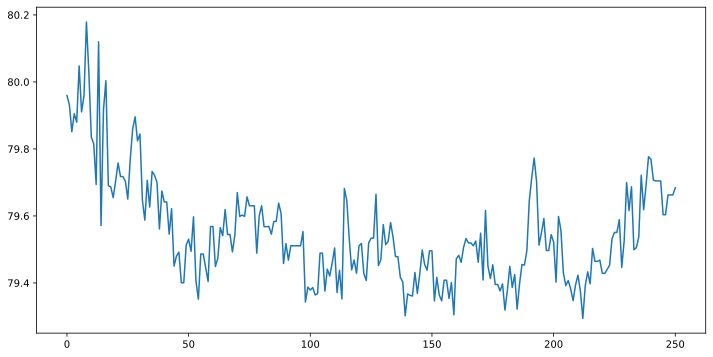

In [ ]:
#Plotando o aprendizado
valores_pop = info.select("max")
plt.figure(figsize = (12,6))
plt.plot(valores_pop)
plt.show()